In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Ad-tech

In [2]:
data = pd.read_csv('data_adtech\AdSmartABdata - AdSmartABdata.csv')
data = data.sort_values(by=['date'], ascending=True)
data

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
4038,818f37f3-dae8-4a33-a22e-e54056e0ba7d,control,2020-07-03,15,Samsung SM-A600FN,6,Chrome Mobile WebView,0,0
3345,6be2edc7-cf48-4831-8edf-3694eb241e09,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3348,6bfed6f0-66e1-4cf8-9871-ff948b5a2afe,exposed,2020-07-03,11,Generic Smartphone,6,Chrome Mobile,0,0
3354,6c3987e1-42ab-4bca-b1c9-3c6e4446f7eb,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3356,6c3cd274-3fba-4a35-97c8-85af0385517a,exposed,2020-07-03,8,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
4764,9812db3b-2c00-472d-8d30-a0b06c813357,exposed,2020-07-10,15,Samsung SM-G960F,6,Chrome Mobile WebView,0,0
4736,97041ed0-0eb3-4306-9ce2-58b24a2226b0,exposed,2020-07-10,16,Samsung SM-G920F,6,Samsung Internet,0,0
4735,96ee2c29-9680-4621-b14c-0c66ec0988e2,control,2020-07-10,7,Generic Smartphone,6,Chrome Mobile WebView,0,1
4865,9b16782b-684f-408f-9fa9-187e902b2fc1,exposed,2020-07-10,7,Generic Smartphone,6,Chrome Mobile,0,1


## Generating pre-experiment AA data
to be used as one CUPED covariate

In [3]:
np.random.seed(42)

mean_yes = data["yes"].mean()
var_yes = data["yes"].var()

desired_variance_reduction = 0.2  # (1 - 0.8)

# Compute the target variance for the covariate
target_variance = (1 - desired_variance_reduction) * var_yes

# Generate the CUPED covariate 'yes_aa'
yes_aa = (data["yes"] - mean_yes) + np.random.normal(0, np.sqrt(target_variance), len(data))
yes_aa = yes_aa.clip(0, 1).astype(int)  # Clip to ensure binary values

data["yes_aa"] = yes_aa

data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,yes_aa
4038,818f37f3-dae8-4a33-a22e-e54056e0ba7d,control,2020-07-03,15,Samsung SM-A600FN,6,Chrome Mobile WebView,0,0,0
3345,6be2edc7-cf48-4831-8edf-3694eb241e09,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0
3348,6bfed6f0-66e1-4cf8-9871-ff948b5a2afe,exposed,2020-07-03,11,Generic Smartphone,6,Chrome Mobile,0,0,0
3354,6c3987e1-42ab-4bca-b1c9-3c6e4446f7eb,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,0
3356,6c3cd274-3fba-4a35-97c8-85af0385517a,exposed,2020-07-03,8,Generic Smartphone,6,Chrome Mobile,0,0,0


In [4]:
from scipy import stats

# Separate the data into control and experimental groups
control_group = data[data['experiment']=='control']['yes']
experimental_group = data[data['experiment']=='exposed']['yes']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(control_group, experimental_group, equal_var=False)

# Display the results
t_stat, p_value

(-2.107278649715408, 0.035124460220699455)

In [5]:
p1 = control_group.sum() / data[data['experiment']=='control']['auction_id'].count()
p2 = experimental_group.sum() / data[data['experiment']=='exposed']['auction_id'].count()
print ('Conversion rate control: ', p1)
print ('Conversion rate treatment: ', p2)

Conversion rate control:  0.06484893146647015
Conversion rate treatment:  0.07688467299051423


In [6]:
p0 = data['yes'].mean()
print('Overall conversion: ', p0)
n = data['auction_id'].nunique()
var0 = p0*(1-p0)
print('Overall var: ', var0)

var1 = data[data['experiment']=='control']['yes'].var()
var2 = data[data['experiment']=='exposed']['yes'].var()

Overall conversion:  0.07081837315835088
Overall var:  0.06580313118155544


### Calculating minimal sample size

In [7]:
delta = p2-p1
za = 1.96
zb = 0.84
min_size = 2*(za+zb)**2 * var0 / delta**2
print('Minimal sample size: ', min_size)

Minimal sample size:  7122.73707263567


## CUPED
Try to find covariate. We first try to find device_make as covariate

In [8]:
# One-hot encoding of browser categories
browser_dummies = pd.get_dummies(data['device_make'], prefix='device', drop_first=True)
data = pd.concat([data, browser_dummies], axis=1)

# Compute theta for each dummy variable
theta = {}
for col in browser_dummies.columns:
    cov_y_x = np.cov(data['yes'], data[col])[0, 1]  # Covariance between data['yes'] and X_i
    var_x = np.var(data[col])  # Variance of X_i
    theta[col] = cov_y_x / var_x if var_x != 0 else 0  # Handle division by zero

# Adjust Y for each browser type
data['browser_sum'] = 0
for col in browser_dummies.columns:
    mean_x = data[col].mean()
    data['browser_sum'] += theta[col] * (data[col] - mean_x)

data['Y_adjusted'] = data['yes'] - data['browser_sum']

In [9]:
var_cuped = data['Y_adjusted'].var()
print('Adjusted variance: ', var_cuped)

correlation = data['yes'].corr(data['browser_sum'])
print(f"The correlation coefficient is: {correlation}")

min_size = 2*(za+zb)**2 * var_cuped / delta**2
print('Adjusted Minimal sample size: ', min_size)

Adjusted variance:  0.06356001110289733
The correlation coefficient is: 0.18496831430003094
Adjusted Minimal sample size:  6879.934727887827


Also test if this covariate is homogeneous between the two groups

In [10]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(data['device_make'], data['experiment'])

# Step 2: Perform the Chi-Square Test of Independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-Square Statistic: 453.2794894355725
p-value: 1.0878252726396005e-11
Degrees of Freedom: 268


## Use OS as covariate

In [11]:
# One-hot encoding of browser categories
os_dummy = pd.get_dummies(data['platform_os'], prefix='OS', drop_first=True)
data = pd.concat([data, os_dummy], axis=1)

# Compute theta for each dummy variable
theta = {}
for col in os_dummy.columns:
    cov_y_x = np.cov(data['yes'], data[col])[0, 1]  # Covariance between data['yes'] and X_i
    var_x = np.var(data[col])  # Variance of X_i
    theta[col] = cov_y_x / var_x if var_x != 0 else 0  # Handle division by zero

# Initialize Y_adjusted as a copy of 'yes'
data['OS_sum'] = 0

# Adjust Y for each browser type
for col in os_dummy.columns:
    mean_x = data[col].mean()
    data['OS_sum'] += theta[col] * (data[col] - mean_x)

data['Y_adjusted_OS'] = data['yes'] - data['OS_sum']

var_cuped = data['Y_adjusted_OS'].var()
print('Adjusted variance: ', var_cuped)

correlation = data['yes'].corr(data['OS_sum'])
print(f"The correlation coefficient is: {correlation}")

min_size = 2*(za+zb)**2 * var_cuped / delta**2
print('Adjusted Minimal sample size: ', min_size)

Adjusted variance:  0.06561532891476819
The correlation coefficient is: 0.05456687237202707
Adjusted Minimal sample size:  7102.408766915995


## Now we choose yes_aa as covariate

In [12]:
cov_y_x = np.cov(data['yes'], data['yes_aa'])[0, 1]  # Covariance between data['yes'] and X_i
var_x = np.var(data['yes_aa'])  # Variance of X_i

# Initialize Y_adjusted as a copy of 'yes'
data['Y_adjusted2'] = data['yes']
theta = cov_y_x / var_x if var_x != 0 else 0

mean_x = data['yes_aa'].mean()
data['Y_adjusted2'] -= theta * (data['yes_aa'] - mean_x)

print(cov_y_x)
print(theta)

var_cuped = data['Y_adjusted2'].var()
print('Adjusted variance: ', var_cuped)

correlation = data['yes'].corr(data['yes_aa'])
print(f"The correlation coefficient is: {correlation}")

min_size = 2*(za+zb)**2 * var_cuped / delta**2
print('Minimal sample size: ', min_size)

0.024506647661871127
0.9544671028333578
Adjusted variance:  0.04242338650656295
The correlation coefficient is: 0.596136046685392
Minimal sample size:  4592.040262998092


# Drawing figures to illustrate CUPED

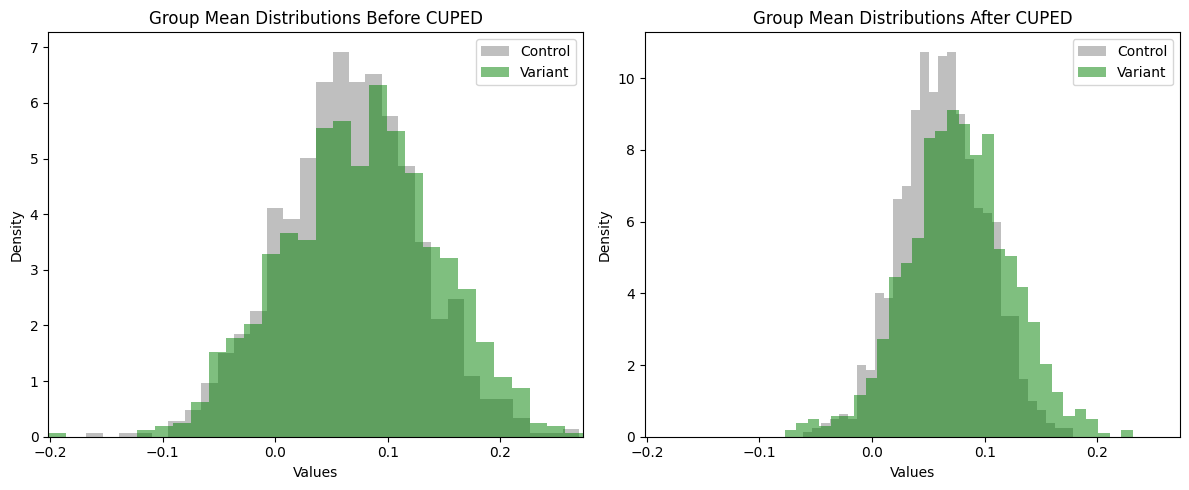

In [13]:
# Simulated "yes" data for control and treatment groups before CUPED
control_yes = np.random.normal(loc=p1, scale=var1, size=1000)
treatment_yes = np.random.normal(loc=p2, scale=var2, size=1000)

var1_cuped = data[data['experiment']=='control']['Y_adjusted2'].var()
var2_cuped = data[data['experiment']=='exposed']['Y_adjusted2'].var()

# Simulated "Y_adjusted" data for control and treatment groups after CUPED
control_adjusted = np.random.normal(loc=p1, scale=var1_cuped, size=1000)
treatment_adjusted = np.random.normal(loc=p2, scale=var2_cuped, size=1000)

x_min = min(control_yes.min(), treatment_yes.min(), control_adjusted.min(), treatment_adjusted.min())
x_max = max(control_yes.max(), treatment_yes.max(), control_adjusted.max(), treatment_adjusted.max())
bins = np.linspace(x_min, x_max, 30)

# Plot distributions before CUPED
plt.figure(figsize=(12, 5))

# Before CUPED
plt.subplot(1, 2, 1)
plt.hist(control_yes, bins=30, alpha=0.5, label="Control", color="gray", density=True)
plt.hist(treatment_yes, bins=30, alpha=0.5, label="Variant", color="green", density=True)
plt.title("Group Mean Distributions Before CUPED")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.xlim(x_min, x_max)

# After CUPED
plt.subplot(1, 2, 2)
plt.hist(control_adjusted, bins=30, alpha=0.5, label="Control", color="gray", density=True)
plt.hist(treatment_adjusted, bins=30, alpha=0.5, label="Variant", color="green", density=True)
plt.title("Group Mean Distributions After CUPED")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.xlim(x_min, x_max)

plt.tight_layout()
plt.show()


## Sequential Test mSPRT

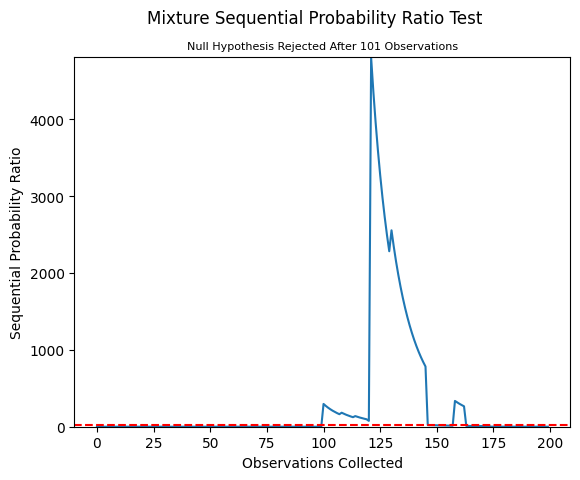

In [14]:
from msprt import msprt

y_cuped_treatment = data[data['experiment']=='exposed']['Y_adjusted2']
y_cuped_control = data[data['experiment']=='control']['Y_adjusted2']

# n = min(len(y_cuped_treatment), len(y_cuped_control))
n=200
y_cuped_control = y_cuped_control[:n]
y_cuped_treatment = y_cuped_treatment[:n]

result = msprt(x=y_cuped_treatment, y=y_cuped_control, sigma=var0)
result.plot()

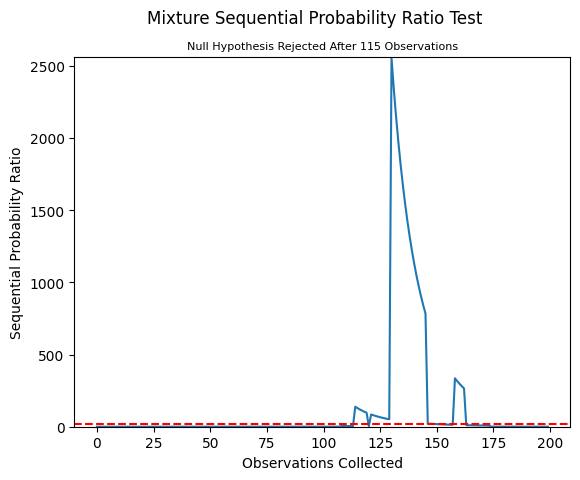

In [15]:
# control_group = data[data['experiment']=='control']['yes']
# experimental_group = data[data['experiment']=='exposed']['yes']
n = min(len(y_cuped_treatment), len(y_cuped_control))
y0_c = control_group[:n]
y0_t = experimental_group[:n]

result = msprt(x=y0_c, y=y0_t, sigma=var0)
result.plot()

## PSM (to reweight features)

Actually I don't wanna do this.... What about let's generate AA test data with necessary associations.

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

data_encoded = pd.get_dummies(data['device_make'], columns=['device_make'], drop_first=True)

X = data_encoded.drop(columns=['auction_id', 'experiment', 'date',  'yes'])  # Exclude experiment and target variable
y = data_encoded['experiment']

# Logistic regression for propensity score estimation
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X, y)
data_encoded['propensity_score'] = logistic.predict_proba(X)[:, 1]  # Propensity scores

# Step 3: Matching
# Split the data into treatment and control groups
treated = data_encoded[data_encoded['experiment'] == 1]
control = data_encoded[data_encoded['experiment'] == 0]

# Use Nearest Neighbors to match control units to treated units based on propensity score
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control indices
control_matched = control.iloc[indices.flatten()].reset_index(drop=True)
treated_matched = treated.reset_index(drop=True)

# Step 4: Combine matched samples
matched_data = pd.concat([treated_matched, control_matched])
matched_data

KeyError: "['auction_id', 'experiment', 'date', 'yes'] not found in axis"